In [1]:
import datetime
import warnings
import math

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt

from dataset import StockDataset
from denoising.autoencoder import *

from metrics import get_metrics
from yahoo_fin_api import load_df

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
df = load_df('data/snp.csv')
df.head(), len(df)

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 1990-02-26  324.160004  328.670013  323.980011  328.670013  328.670013   
 1990-02-27  328.679993  331.940002  328.470001  330.260010  330.260010   
 1990-02-28  330.260010  333.480011  330.160004  331.890015  331.890015   
 1990-03-01  331.890015  334.399994  331.079987  332.739990  332.739990   
 1990-03-02  332.739990  335.540009  332.720001  335.540009  335.540009   
 
                Volume        Mean  
 Date                               
 1990-02-26  148900000  326.370010  
 1990-02-27  152590000  329.837502  
 1990-02-28  184400000  331.447510  
 1990-03-01  157930000  332.527496  
 1990-03-02  164330000  334.135002  ,
 8313)

The Reason to use time stamp rather than `train_test_split` is to make test data unseen.

In [3]:
#df[df.columns] = MinMaxScaler().fit_transform(df.values)

In [4]:
TRAIN_SIZE = 0.7
cut_idx = df.iloc[int(len(df) * TRAIN_SIZE)].name
data = df['Mean']
data_min, data_max = data.min(), data.max()
train_data = data[data.index <= cut_idx]
test_data = data[cut_idx < data.index]

print(train_data.tail())
print('=' * 10)
print(test_data.head())

Date
2013-03-25    1554.927490
2013-03-26    1557.774963
2013-03-27    1560.642487
2013-03-28    1565.852478
2013-04-01    1565.097504
Name: Mean, dtype: float64
Date
2013-04-02    1567.062531
2013-04-03    1561.302490
2013-04-04    1557.197479
2013-04-05    1553.184998
2013-04-08    1557.007477
Name: Mean, dtype: float64


In [5]:
data = torch.tensor(df['Mean'], dtype=torch.float32).unsqueeze(0)
train_data = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0)
test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)

data

tensor([[ 326.3700,  329.8375,  331.4475,  ..., 4024.3076, 3996.7876,
         4007.1025]])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
torch.manual_seed(0)

## CNN Stacked AutoEncoder

In [7]:
CONV1_KERNEL = 51
CONV2_KERNEL = 51
CONV3_KERNEL = 51
STRIDE1 = 1
STRIDE2 = 1
STRIDE3 = 1

num_epoch = 85

In [8]:
cnn_encoder = CnnEncoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL, STRIDE1, STRIDE2, STRIDE3).to(device)
cnn_decoder = CnnDecoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL, STRIDE1, STRIDE2, STRIDE3).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(cnn_encoder.parameters()) + list(cnn_decoder.parameters()), lr = 1e-4, weight_decay=1e-5)
# Currently ADAM is not need. But I used ADAM for the future.

In [9]:
print('CNN Encoder:')
print(cnn_encoder)
print('=' * 90)
print('CNN Decoder:')
print(cnn_decoder)

CNN Encoder:
CnnEncoder(
  (encoder_cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(51,), stride=(1,), padding=(51,))
    (1): ReLU(inplace=True)
    (2): Conv1d(8, 16, kernel_size=(51,), stride=(1,), padding=(51,))
    (3): ReLU(inplace=True)
    (4): Conv1d(16, 32, kernel_size=(51,), stride=(1,), padding=(51,))
    (5): ReLU(inplace=True)
    (6): Conv1d(32, 64, kernel_size=(51,), stride=(1,), padding=(51,))
    (7): ReLU(inplace=True)
  )
)
CNN Decoder:
CnnDecoder(
  (decoder_cnn): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(51,), stride=(1,), padding=(51,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(32, 16, kernel_size=(51,), stride=(1,), padding=(51,))
    (3): ReLU(inplace=True)
    (4): ConvTranspose1d(16, 8, kernel_size=(51,), stride=(1,), padding=(51,))
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(8, 1, kernel_size=(51,), stride=(1,), padding=(51,))
  )
)


In [ ]:
train_loss = []

cnn_encoder.train()
cnn_decoder.train()

for epoch in range(num_epoch):
    encoded_data = cnn_encoder(data)
    decoded_data = cnn_decoder(encoded_data)

    loss = criterion(decoded_data, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.detach().cpu().numpy())

    plot_epoch = num_epoch - np.floor(num_epoch * np.log10(np.linspace(1, 10, 20)))
    if epoch in plot_epoch or epoch == num_epoch - 1:
        df['CNNPredMean'] = cnn_decoder(cnn_encoder(data)).detach().cpu().numpy().squeeze()
        #df['LSTMPredMean'] = lstm_decoder(lstm_encoder(data)).detach().cpu().numpy().squeeze()
        plt.ylim([data_min, data_max])
        df[['Mean', 'CNNPredMean']].plot(color=['b', 'r'], figsize=(18, 10))
        plt.savefig(f'plots/CNN-kernel51-epoch{epoch}.png')

train_loss = pd.Series(train_loss).astype(np.float32)

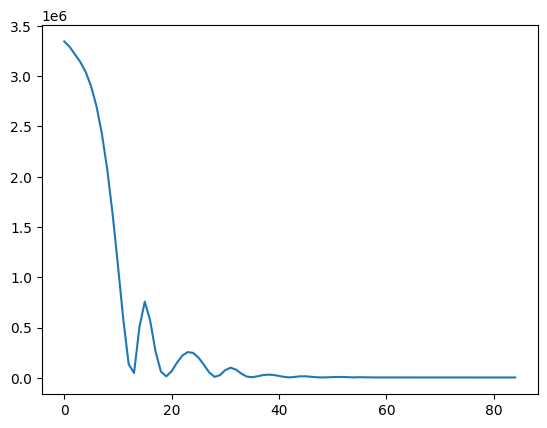

In [11]:
_ = train_loss.plot.line()

## LSTM Stacked AutoEncoder

In [12]:
#lstm_encoder = LstmEncoder()

## Visulizing Result

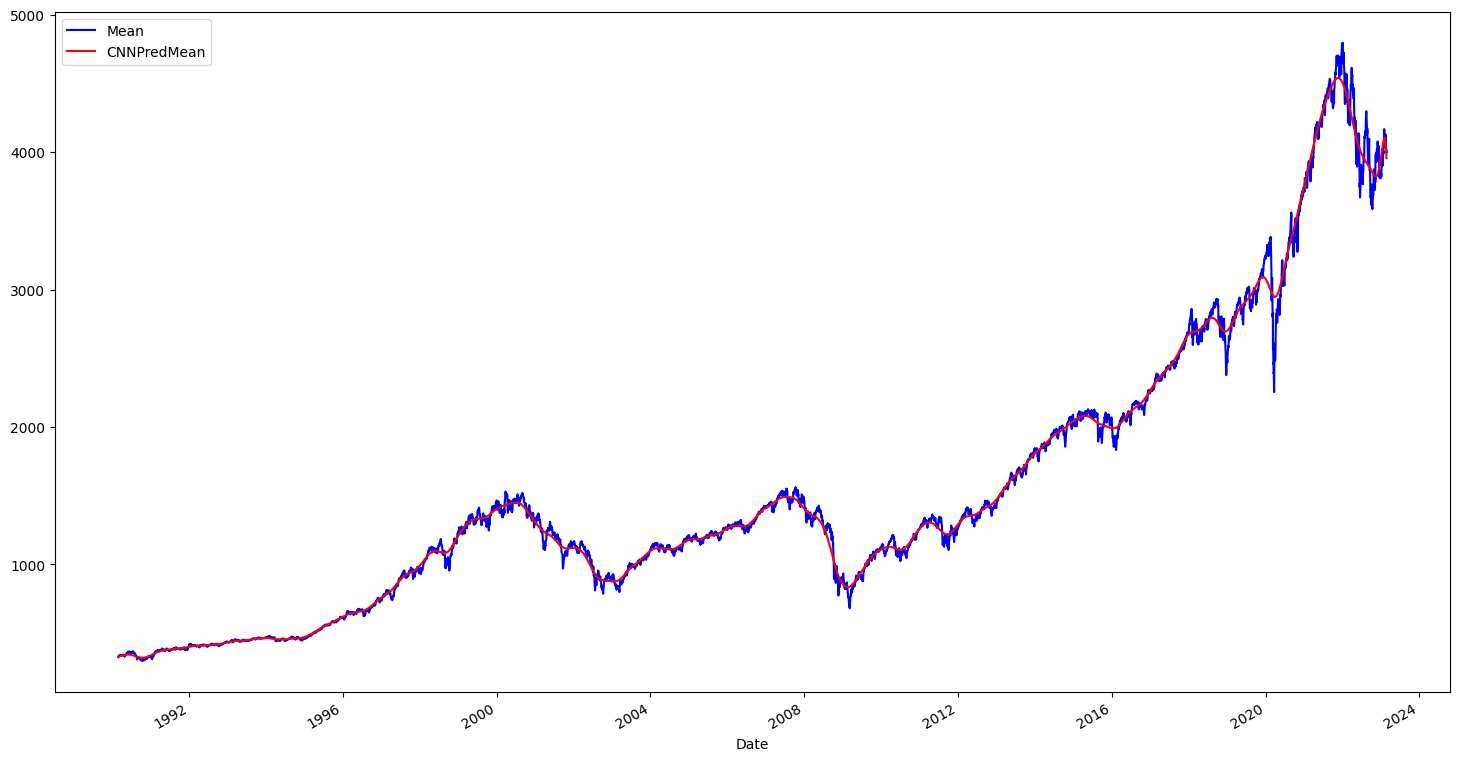

In [13]:
df['CNNPredMean'] = cnn_decoder(cnn_encoder(data)).detach().cpu().numpy().squeeze()
#df['LSTMPredMean'] = lstm_decoder(lstm_encoder(data)).detach().cpu().numpy().squeeze()
_ = df[['Mean', 'CNNPredMean']].plot(color=['b', 'r'], figsize=(18, 10))

In [14]:
result_dict = {
        'S&P 500': df[['Mean', 'CNNPredMean']].rename(columns={'Mean': 'True', 'CNNPredMean': 'CNNPred'})
    }

get_metrics(result_dict, 'Data')

,mean_squared_error,R-squared,snr,psnr
Data,,,,
S&P 500,3368.731241,0.996685,29.939615,38.346061


In [15]:
torch.cuda.empty_cache()

In [16]:
raise RuntimeError # For preventing unwanted saving

RuntimeError: 

In [ ]:
NOW_STR = datetime.datetime.now().strftime('%d%m%Y-%H%M%S')

torch.save(cnn_encoder.state_dict(), f'./model-dir/{NOW_STR}-cnn-encoder.pt')
torch.save(cnn_decoder.state_dict(), f'./model-dir/{NOW_STR}-cnn-decoder.pt')
#torch.save(lstm_encoder.state_dict(), f'./model-dir/{NOW_STR}-lstm-encoder.pt')
#torch.save(lstm_decoder.state_dict(), f'./model-dir/{NOW_STR}-lstm-decoder.pt')